In [73]:
import pandas as pd
import string
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

In [2]:

# Ensure NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:

# Load the datasets
news_df = pd.read_csv('./data/us_equities_news_dataset.csv')
stock_df = pd.read_csv('./data/NVDA.csv')

In [4]:
'''

This is the initial document filtering but the number of articles is too high to process in my laptop.

# Convert the date columns to datetime format for matching
news_df['Date'] = pd.to_datetime(news_df['release_date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Merge news data with stock prices based on publication date
merged_df = pd.merge(news_df, stock_df, on='Date', how='inner')

# Filter to keep only articles that have matching stock data
filtered_df = merged_df[['content', 'Open', 'Close', 'Date']]

# Label the target variable based on the opening and closing prices
filtered_df['target'] = np.where(filtered_df['Open'] > filtered_df['Close'], 0, 1)

# Display the first few rows to verify the merging and labeling
print("\nFiltered and Labeled Data:")
print(filtered_df.head())

'''

'\n\nThis is the initial document filtering but the number of articles is too high to process in my laptop.\n\n# Convert the date columns to datetime format for matching\nnews_df[\'Date\'] = pd.to_datetime(news_df[\'release_date\'])\nstock_df[\'Date\'] = pd.to_datetime(stock_df[\'Date\'])\n\n# Merge news data with stock prices based on publication date\nmerged_df = pd.merge(news_df, stock_df, on=\'Date\', how=\'inner\')\n\n# Filter to keep only articles that have matching stock data\nfiltered_df = merged_df[[\'content\', \'Open\', \'Close\', \'Date\']]\n\n# Label the target variable based on the opening and closing prices\nfiltered_df[\'target\'] = np.where(filtered_df[\'Open\'] > filtered_df[\'Close\'], 0, 1)\n\n# Display the first few rows to verify the merging and labeling\nprint("\nFiltered and Labeled Data:")\nprint(filtered_df.head())\n\n'

In [5]:
# Sample keywords related to NVIDIA and associated companies
nvidia_keywords = [
    'NVDA', 'NVIDIA','GPU', 'GRAPHICS']

'''

More keywords can be added to the list to improve the filtering process. But adding all those increases the document number significantly making processing slower and creating memory issues that are unsolvable by my mere laptop. 

nvidia_keywords = [
    'NVDA', 'NVIDIA', 'NIO', 'UBER', 'AMZN', 'AMAZON', 'TESLA', 'AI', 'GPU', 'GRAPHICS',
    'CHIP', 'SEMICONDUCTOR', 'AUTONOMOUS', 'DRIVING', 'DEEP LEARNING', 'MACHINE LEARNING'
]

'''
# Compile a regex pattern from the keywords list
nvidia_pattern = '|'.join(nvidia_keywords)  # Combines the keywords into a regex pattern

# Filter articles where the content or ticker column contains any of the keywords
nvidia_related_articles = news_df[
    news_df['content'].str.contains(nvidia_pattern, case=False, na=False) |
    news_df['ticker'].str.contains(nvidia_pattern, case=False, na=False)
]

# Display the count of NVIDIA-related articles
print(f"\nTotal NVIDIA-related articles found: {nvidia_related_articles.shape[0]}")

# Convert the date columns to datetime format for matching
nvidia_related_articles['Date'] = pd.to_datetime(nvidia_related_articles['release_date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Merge filtered news data with stock prices based on publication date
merged_df = pd.merge(nvidia_related_articles, stock_df, on='Date', how='inner')

# Filter to keep only articles that have matching stock data
filtered_df = merged_df[['content', 'Open', 'Close', 'Date']]

# Label the target variable based on the opening and closing prices
filtered_df['target'] = np.where(filtered_df['Open'] > filtered_df['Close'], 0, 1)

# Display the first few rows to verify the merging and labeling
print("\nFiltered and Labeled Data:")
print(filtered_df.head())


Total NVIDIA-related articles found: 4982

Filtered and Labeled Data:
                                             content     Open    Close  \
0  ECB Effects\nThe move in the euro was huge  fa...  3.77750  3.73150   
1  6 Stocks To Watch  March 6 Trading Session\nSt...  3.90400  3.80125   
2  Investing com   A rout in Apple and Facebook  ...  4.04475  3.61750   
3  With 4 500 companies bringing their innovation...  6.19300  6.22325   
4  With 4 500 companies bringing their innovation...  6.18325  6.10800   

        Date  target  
0 2019-03-07       0  
1 2019-03-06       0  
2 2018-11-19       0  
3 2020-01-16       1  
4 2020-01-10       0  


C:\Users\georg\AppData\Local\Temp\ipykernel_24080\1444243054.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_related_articles['Date'] = pd.to_datetime(nvidia_related_articles['release_date'])
C:\Users\georg\AppData\Local\Temp\ipykernel_24080\1444243054.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['target'] = np.where(filtered_df['Open'] > filtered_df['Close'], 0, 1)


In [6]:
# Check for duplicate documents based on the 'content' column
duplicate_docs = filtered_df[filtered_df['content'].duplicated(keep=False)]

# Display the duplicate documents (if any)
print(f"Number of duplicate documents found: {duplicate_docs.shape[0]}")
if not duplicate_docs.empty:
    print("Duplicate Documents:")
    print(duplicate_docs[['content']])

# Remove duplicate documents, keeping the first occurrence
filtered_df = filtered_df.drop_duplicates(subset='content', keep='first').reset_index(drop=True)

# Display the updated DataFrame
print(f"Number of documents after removing duplicates: {filtered_df.shape[0]}")


Number of duplicate documents found: 19
Duplicate Documents:
                                                content
1347  EquitiesAsian markets rose on Friday  followin...
1348  EquitiesAsian markets rose on Friday  followin...
1349  EquitiesAsian markets rose on Friday  followin...
1350  EquitiesAsian markets rose on Friday  followin...
1351  EquitiesAsian markets rose on Friday  followin...
1352  EquitiesAsian markets rose on Friday  followin...
1353  EquitiesAsian markets rose on Friday  followin...
1354  EquitiesAsian markets rose on Friday  followin...
1355  EquitiesAsian markets rose on Friday  followin...
1356  EquitiesAsian markets rose on Friday  followin...
1357  EquitiesAsian markets rose on Friday  followin...
1358  EquitiesAsian markets rose on Friday  followin...
1359  EquitiesAsian markets rose on Friday  followin...
1614  Advanced Micro Devices   NASDAQ AMD   reported...
1615  Advanced Micro Devices   NASDAQ AMD   reported...
1617  Semiconductor stocks have been mixed 

In [7]:

# Basic descriptive statistics for the news dataset
num_articles = filtered_df.shape[0]
average_words_per_article = filtered_df['content'].apply(lambda x: len(str(x).split())).mean()
print(f'The number of articles before filtering is: {news_df.shape[0]}')
print(f"The number of articles after filtering is: {num_articles}")
print(f"The average amount of words per article is: {average_words_per_article}")

The number of articles before filtering is: 221513
The number of articles after filtering is: 4410
The average amount of words per article is: 765.684126984127


In [8]:
# Initialize the stemmer
stemmer = PorterStemmer()


In [9]:

# Tokenize content for word frequency analysis
filtered_df.loc[:, 'text_length'] = filtered_df['content'].apply(lambda x: len(str(x).split()))

In [10]:
# Tokenize content for word frequency analysis
filtered_df.loc[:, 'processed_text'] = filtered_df['content'].apply(lambda x: word_tokenize(str(x).lower()))

In [11]:
# Remove stopwords and punctuation for better NLP insights
stop_words = set(stopwords.words('english'))
# Remove stopwords, punctuation, and apply stemming
filtered_df.loc[:, 'filtered_text'] = filtered_df['processed_text'].apply(
    lambda words: [stemmer.stem(word) for word in words if word.isalpha() and word not in stop_words]
)

In [12]:
# Join the filtered words back into strings for TF-IDF
filtered_df.loc[:, 'filtered_text_str'] = filtered_df['filtered_text'].apply(lambda x: ' '.join(x))

In [13]:
# Frequency analysis of the most common words
all_words = [word for content in filtered_df['filtered_text'] for word in content]
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(50)

# Display the most common words in the news dataset
print("\nTop 50 most common words in the news articles (after stop word removal):")
print(most_common_words)


Top 50 most common words in the news articles (after stop word removal):
[('year', 23382), ('compani', 21079), ('stock', 18241), ('nasdaq', 15348), ('market', 14565), ('zack', 14347), ('earn', 13033), ('quarter', 12085), ('growth', 11371), ('share', 10750), ('expect', 9398), ('revenu', 9045), ('report', 8665), ('also', 8376), ('billion', 8148), ('nvidia', 8074), ('trade', 8054), ('nyse', 7789), ('estim', 7613), ('invest', 7402), ('new', 7361), ('like', 7351), ('million', 7133), ('price', 6959), ('rank', 6860), ('technolog', 6760), ('industri', 6538), ('last', 6260), ('investor', 6254), ('inc', 6250), ('buy', 5713), ('product', 5656), ('time', 5640), ('per', 5405), ('one', 5397), ('u', 5365), ('increas', 5266), ('rate', 5243), ('high', 5113), ('current', 5070), ('gain', 5053), ('sale', 5040), ('p', 5025), ('day', 4956), ('said', 4917), ('busi', 4838), ('see', 4825), ('strong', 4796), ('data', 4747), ('week', 4628)]


In [14]:
# TF-IDF Representation of Documents using the processed and filtered text
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)  # Reduced max features
tfidf_matrix = vectorizer.fit_transform(filtered_df['filtered_text_str'])

In [15]:
# Train a linear classifier (e.g., Logistic Regression) on the TF-IDF matrix
clf = LogisticRegression(max_iter=1000)
clf.fit(tfidf_matrix, filtered_df['target'])

LogisticRegression(max_iter=1000)

In [16]:
def print_top_features(vectorizer, coef):
    """Prints features with the highest coefficient values for binary classification."""
    feature_names = vectorizer.get_feature_names_out()
    
    # Top 20 features with the most negative coefficients (indicative of Class 0)
    top_features_class_0 = np.argsort(coef)[:20]
    print("\nTop 20 Words Indicative of Class 0 (Stock Price Down):")
    print(" ".join(feature_names[j] for j in top_features_class_0))
    
    # Top 20 features with the most positive coefficients (indicative of Class 1)
    top_features_class_1 = np.argsort(coef)[-20:]
    print("\nTop 20 Words Indicative of Class 1 (Stock Price Up):")
    print(" ".join(feature_names[j] for j in top_features_class_1))
    
    return top_features_class_0, top_features_class_1

# Extract the coefficients from the classifier
coef = clf.coef_[0]

# Print the most informative features and get the indices for visualization
top_features_class_0, top_features_class_1 = print_top_features(vectorizer, coef)


Top 20 Words Indicative of Class 0 (Stock Price Down):
fell pay net level beat china notabl power work today second recent busi friday expand test tuesday talk trade charg

Top 20 Words Indicative of Class 1 (Stock Price Up):
amazon dollar cloud esp video provid mark total reflect gain autonom comput chip maker govern electron global deliv pressur rose


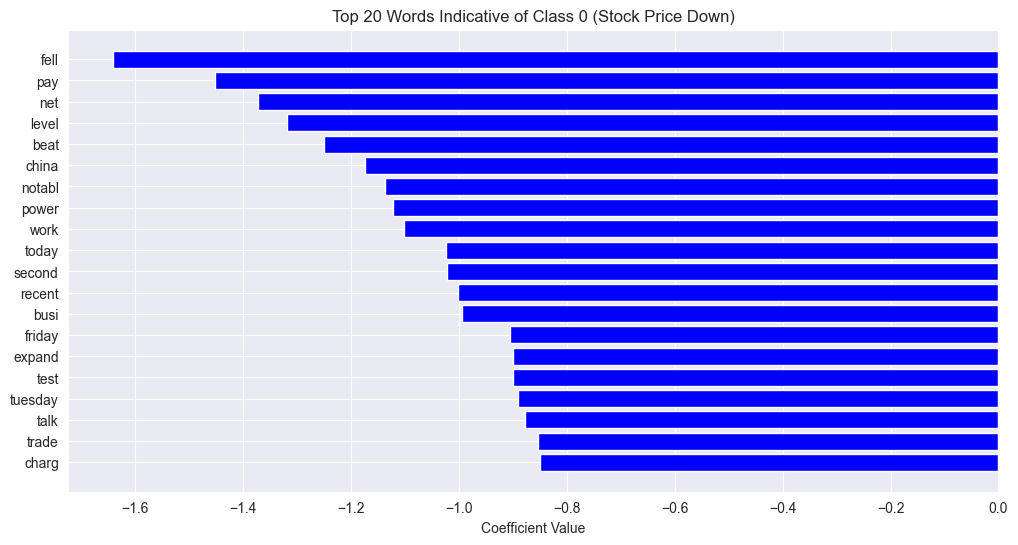

In [17]:

# Visualize the top features for Class 0 (Stock Price Down)
plt.figure(figsize=(12, 6))
plt.barh([vectorizer.get_feature_names_out()[i] for i in top_features_class_0], coef[top_features_class_0], color='blue')
plt.title('Top 20 Words Indicative of Class 0 (Stock Price Down)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.show()



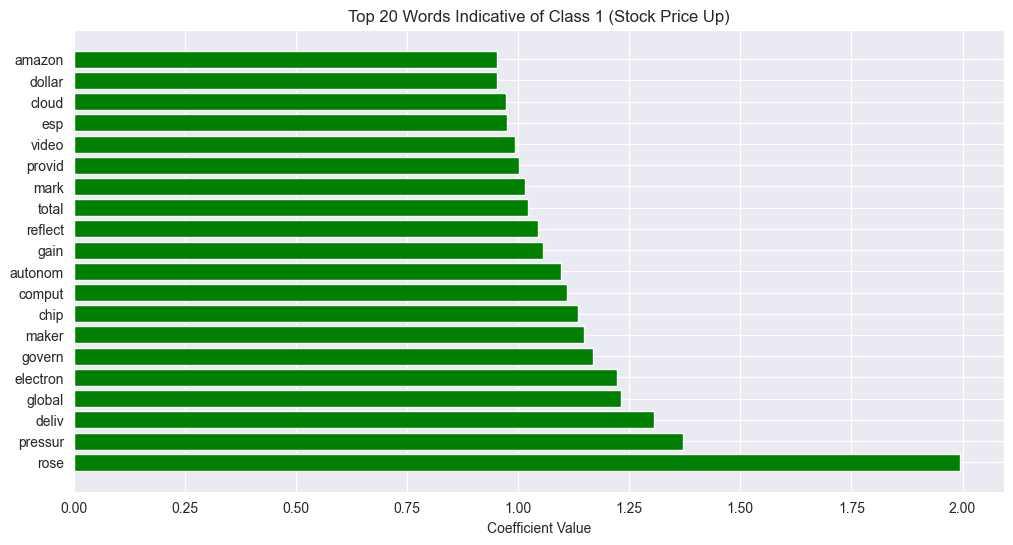

In [18]:
# Visualize the top features for Class 1 (Stock Price Up)
plt.figure(figsize=(12, 6))
plt.barh([vectorizer.get_feature_names_out()[i] for i in top_features_class_1], coef[top_features_class_1], color='green')
plt.title('Top 20 Words Indicative of Class 1 (Stock Price Up)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.show()

In [19]:
# Check the shape of the tfidf_matrix
print(f"Shape of tfidf_matrix: {tfidf_matrix.shape}")

# Number of documents (rows) and terms (columns)
num_documents, num_features = tfidf_matrix.shape
print(f"Number of documents: {num_documents}")
print(f"Number of features (terms): {num_features}")

# Check the number of non-zero elements
non_zero_elements = tfidf_matrix.nnz
print(f"Number of non-zero elements: {non_zero_elements}")

# Calculate the total number of elements
total_elements = num_documents * num_features
print(f"Total number of elements: {total_elements}")

# Calculate the sparsity of the matrix
sparsity = (1 - (non_zero_elements / total_elements)) * 100
print(f"Sparsity of the tfidf_matrix: {sparsity:.2f}%")

Shape of tfidf_matrix: (4410, 500)
Number of documents: 4410
Number of features (terms): 500
Number of non-zero elements: 490901
Total number of elements: 2205000
Sparsity of the tfidf_matrix: 77.74%


In [20]:
# Compute cosine similarity matrix, which measures the similarity between documents

similarity_matrix = cosine_similarity(tfidf_matrix)

# Convert similarity matrix to a DataFrame for easier handling
similarity_df = pd.DataFrame(similarity_matrix)

In [21]:
# Check the shape of the similarity_matrix
print(f"Shape of similarity_matrix: {similarity_matrix.shape}")

# Number of documents (rows and columns since it's square)
num_documents = similarity_matrix.shape[0]
print(f"Number of documents: {num_documents}")

# Check the number of non-zero elements in the similarity matrix
non_zero_elements = np.count_nonzero(similarity_matrix)
print(f"Number of non-zero elements: {non_zero_elements}")

# Calculate the total number of elements in the similarity matrix
total_elements = num_documents * num_documents
print(f"Total number of elements: {total_elements}")

# Calculate the sparsity of the similarity matrix
sparsity = (1 - (non_zero_elements / total_elements)) * 100
print(f"Sparsity of the similarity_matrix: {sparsity:.2f}%")

Shape of similarity_matrix: (4410, 4410)
Number of documents: 4410
Number of non-zero elements: 19410366
Total number of elements: 19448100
Sparsity of the similarity_matrix: 0.19%


In [22]:
# Find indices of the most and least similar documents (excluding self-similarity)
np.fill_diagonal(similarity_matrix, 0.0001)

In [23]:
# Find the maximum value in the similarity matrix
max_similarity = np.max(similarity_matrix)
print(f"Maximum similarity value (excluding self-similarity): {max_similarity}")

# Find the minimum value in the similarity matrix
min_similarity = np.min(similarity_matrix)
print(f"Minimum similarity value (excluding self-similarity): {min_similarity}")

Maximum similarity value (excluding self-similarity): 1.0000000000000002
Minimum similarity value (excluding self-similarity): 0.0


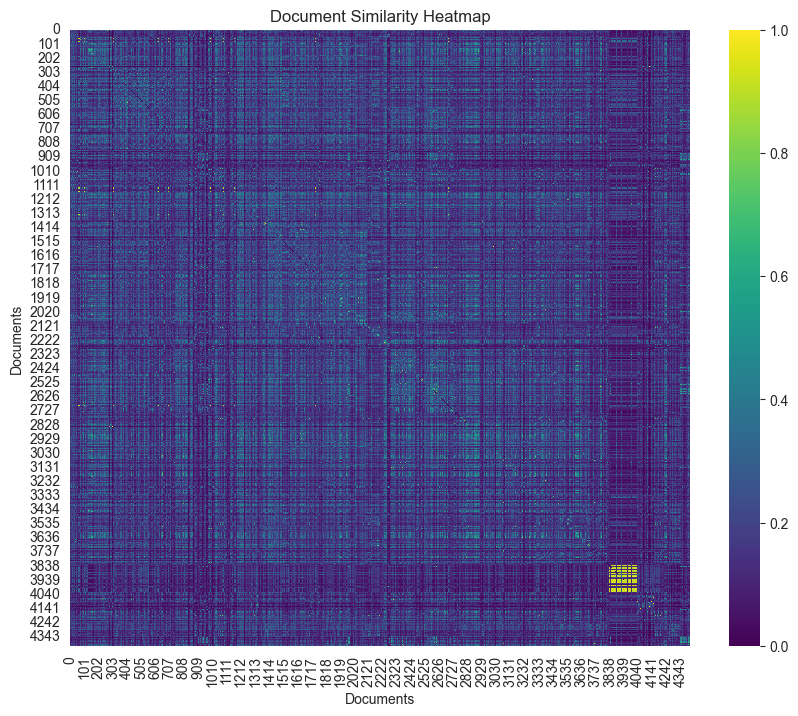

In [24]:

# Create a heatmap of the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis', cbar=True)
plt.title('Document Similarity Heatmap')
plt.xlabel('Documents')
plt.ylabel('Documents')
plt.show()

https://datascience.stackexchange.com/questions/101862/cosine-similarity-between-sentence-embeddings-is-always-positive



In [25]:
most_similar_indices = np.unravel_index(np.argmax(similarity_matrix, axis=None), similarity_matrix.shape)
least_similar_indices = np.unravel_index(np.argmin(similarity_matrix, axis=None), similarity_matrix.shape)

In [26]:
# Inspect the most similar documents 
similar_doc_1 = filtered_df.iloc[most_similar_indices[0]]
similar_doc_2 = filtered_df.iloc[most_similar_indices[1]]

print("\nMost Similar Documents:\n")
print("Document 1:")
print(similar_doc_1['content'])
print("\nDocument 2:")
print(similar_doc_2['content'])


Most Similar Documents:

Document 1:
AAXN  ACAD  ACIA  ALRM  APEI  ARNA  ATHX  AXAS  BUFF  CALX  CDXS  CHEF  CHMI  CLI  COGT  COHR  DEPO  DIOD  DIS  DOX  EA  ENPH  ESIO  EVH  EVRI  EXAR  FARM  FARO  FMI  FNV  FOSL  FTD  FUEL  GDOT  GERN  GHDX  GWPH  HALO  HCKT  IAG  INFI  INGN  IOSP  IPAR  JAZZ  KAR  LADR  LGND  MCF  MCHP  MIME  MMI  MRIN  MTRX  MXL  MXWL  NBIX  NDLS  NEWR  NKTR  NUAN  NVDA  NWSA  OREX  OVAS  PAAS  PCLN  PEIX  PEN  PFMT  PHH  PRAA  PRI  PRMW  PRTA  PSEC  QNST  REG  REXX  RMTI  RPD  RVNC  SCSC  SGRY  SLF  SLW  SPA  SPWR  SSNI  TCX  TRIP  TSRO  TRUE  TTEC  TWNK  VSLR  VTL  WAIR  WR  WSTC  XCO  XOG  XOXO  YELP  YUME  ZAYO Now read 

Document 2:
PRTO  42  MTBC  19  CROX  15  MNKD  14  HPJ  13  NVDA  13  MYSZ  13  INCR  12  ARRY  12  ANF  11  ONCS  11  ICON  10  ATHX  8  EA  8  COTY  7  NAK  8  IPXL  7  AAXN  7  IAG  6  TRIP  6  MCHP  5  WIX  5  Now read 


In [27]:

# Inspect the least similar documents
dissimilar_doc_1 = filtered_df.iloc[least_similar_indices[0]]
dissimilar_doc_2 = filtered_df.iloc[least_similar_indices[1]]

print("\n\nMost Dissimilar Documents:\n")
print("Document 1:")
print(dissimilar_doc_1['content'])
print("\nDocument 2:")
print(dissimilar_doc_2['content'])





Most Dissimilar Documents:

Document 1:
US MarketsS P 500 Futures  8 pointsUS 10 Year 1 78 VIX 12 46Oil  57 76Dollar Index 98 28International MarketsJapan  0 78 HK  1 5 China  0 72 SK  1 02 Germany  0 47 UK  0 68 




MACRO
S P 500
S P 500 Futures are pointing to a higher opening on November 25 following global markets higher  The boost follows headlines  China is stepping up IP protection and enforcement  Also  helping to lift stocks was news that HK voters overwhelmingly voted in favor of pro democracy candidates in the latest elections  As a result  the S P 500 futures are rising to 3120  
STOCKSNETFLIX  NFLX  
Netflix  NASDAQ NFLX  is falling a just touch this morning after  Wells Fargo   NYSE WFC  downgraded the stock to Underperform from Market Perform  The stock has generally been trending higher  and I don t think this will do much to derail the stock move towards  320 




UBER  UBER 
Uber  NYSE UBER  is falling some this morning after it was reported the company is losing i

In [ ]:
# Prepare the text data for Word2Vec
sentences = filtered_df['filtered_text'].tolist()

In [48]:
def document_embedding_tfidf(model, document, tfidf, feature_names, vector_size=100):
    """
    Compute a TF-IDF weighted document embedding by averaging the Word2Vec embeddings of words in the document.

    Parameters:
    - model: Trained Word2Vec model
    - document: List of tokenized words
    - tfidf: TfidfVectorizer object used for the document
    - feature_names: The list of features (terms) from the TF-IDF vectorizer
    - vector_size: Size of the word embeddings in the Word2Vec model

    Returns:
    - doc_embedding: The TF-IDF weighted document embedding as a numpy array
    """
    word_vectors = []
    weights = []

    # Extract the TF-IDF scores for the document
    tfidf_scores = tfidf.transform([" ".join(document)])
    tfidf_scores = tfidf_scores.toarray().flatten()

    feature_names = feature_names.tolist()  # Convert NumPy array to list

    for word in document:
        if word in model.wv.index_to_key and word in feature_names:
            # Get the word embedding
            word_vector = model.wv[word]
            word_index = feature_names.index(word)  # Get the index of the word in the TF-IDF feature list

            # Get the TF-IDF weight for this word
            tfidf_weight = tfidf_scores[word_index]

            # Collect the word vector and weight
            word_vectors.append(word_vector)
            weights.append(tfidf_weight)

    if len(word_vectors) == 0:
        # Return a zero vector if no words from the document are in the Word2Vec model
        return np.zeros(vector_size)

    # Convert lists to arrays
    word_vectors = np.array(word_vectors)
    weights = np.array(weights)

    # Compute the weighted average of word vectors
    doc_embedding = np.average(word_vectors, axis=0, weights=weights)

    return doc_embedding


tfidf_feature_names = vectorizer.get_feature_names_out()

# Apply the function to all documents in filtered dataframe
filtered_df['doc_embedding'] = filtered_df['filtered_text'].apply(
    lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names)
)


In [70]:
# Define the grid of parameters to test
'''
vector_sizes = [100, 200, 300]
window_sizes = [3, 5, 7]
min_counts = [1, 5, 10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]
'''

Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5306
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5317
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5215
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5215
Best Model Parameters: Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20
Best Model Accuracy: 0.5317


In [72]:
from gensim.models import Word2Vec
import itertools


# Define the grid of parameters to test
vector_sizes = [200, 300]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]

# Iterate over all combinations of parameters
best_score = 0
best_params = None
best_model = None

for vector_size, window, min_count, sg, epoch in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs):
    # Initialize Word2Vec with current hyperparameters
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)
    
    # Convert sentences to document embeddings
    doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]
    
    #Checking for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = filtered_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Train a simple classifier (e.g., Logistic Regression) on the embeddings
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Get the accuracy on the test set
    accuracy = lr_model.score(X_test, y_test)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}")
    
    # Track the best model
    if accuracy > best_score:
        best_score = accuracy
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Best Model Accuracy: {best_score:.4f}")


Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5306, F1 Score: 0.5476
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5374, F1 Score: 0.5476
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5215, F1 Score: 0.5476
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5193, F1 Score: 0.5476
Vector Size: 300, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5374, F1 Score: 0.5476
Vector Size: 300, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5533, F1 Score: 0.5476
Vector Size: 300, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5454, F1 Score: 0.5476
Vector Size: 300, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5363, F1 Score: 0.5476
Best Model Parameters: Vector Size: 300, Window: 3, Min Count: 10, SG: 0, Epochs: 20
Best Model Accuracy: 0.5533


In [71]:
from gensim.models import Word2Vec
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score


sentences = filtered_df['filtered_text'].tolist()

# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]

# Iterate over all combinations of parameters
best_score = 0
best_params = None
best_model = None

for vector_size, window, min_count, sg, epoch in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs):
    # Initialize Word2Vec with current hyperparameters
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)
    
    # Convert sentences to document embeddings by averaging the word vectors
    doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]
    
    #Checking empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = filtered_df['target']
    
    # Splitting the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Initializing and train Naive Bayes on the document embeddings
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    # Predicting the test set
    y_pred = nb_model.predict(X_test)
    
    # Evaluating the model using accuracy and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Tracking the best model based on accuracy or F1-score
    if accuracy > best_score:
        best_score = accuracy
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Best Model Accuracy: {best_score:.4f}")


Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5420, F1 Score: 0.5647
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5261, F1 Score: 0.5417
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5317, F1 Score: 0.5545
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5261, F1 Score: 0.5476
Best Model Parameters: Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10
Best Model Accuracy: 0.5420


In [74]:
# TF-IDF Representation of Documents using the processed and filtered text
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Reduced max features
tfidf_matrix = vectorizer.fit_transform(filtered_df['filtered_text_str'])

In [75]:
# Prepare the text data for Word2Vec
sentences = filtered_df['filtered_text'].tolist()

In [78]:
from gensim.models import Word2Vec
import itertools
import numpy as np


# Define the grid of parameters to test
vector_sizes = [200, 300]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]

# Initialize TF-IDF vectorizer and compute feature names
tfidf_feature_names = vectorizer.get_feature_names_out()

# Iterate over all combinations of parameters
best_score = 0
best_params = None
best_model = None

for vector_size, window, min_count, sg, epoch in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs):
    # Initialize Word2Vec with current hyperparameters
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)

    # Generate document embeddings using TF-IDF weighted Word2Vec
    doc_embeddings = filtered_df['filtered_text'].apply(
        lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names, vector_size=vector_size)
    ).tolist()
    
    # Ensure embeddings have no None or empty values
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = filtered_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Train a simple classifier (e.g., Logistic Regression) on the embeddings
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Get the accuracy on the test set
    accuracy = lr_model.score(X_test, y_test)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}")
    
    # Track the best model
    if accuracy > best_score:
        best_score = accuracy
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Best Model Accuracy: {best_score:.4f}")


Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5170
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5272
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5125
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5159
Vector Size: 300, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5125
Vector Size: 300, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5238
Vector Size: 300, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5215
Vector Size: 300, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5249
Best Model Parameters: Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20
Best Model Accuracy: 0.5272


In [80]:
from gensim.models import Word2Vec
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB


sentences = filtered_df['filtered_text'].tolist()

# Define the grid of parameters to test
vector_sizes = [200, 300]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]

# Initialize TF-IDF vectorizer and compute feature names
tfidf_feature_names = vectorizer.get_feature_names_out()

# Define a function to compute document embeddings using TF-IDF weighted Word2Vec
def document_embedding_tfidf(model, document, tfidf, feature_names, vector_size=100):
    word_vectors = []
    weights = []

    # Extract the TF-IDF scores for the document
    tfidf_scores = tfidf.transform([" ".join(document)])
    tfidf_scores = tfidf_scores.toarray().flatten()

    feature_names = feature_names.tolist()  # Convert NumPy array to list

    for word in document:
        if word in model.wv.index_to_key and word in feature_names:
            # Get the word embedding
            word_vector = model.wv[word]
            word_index = feature_names.index(word)  # Get the index of the word in the TF-IDF feature list

            # Get the TF-IDF weight for this word
            tfidf_weight = tfidf_scores[word_index]

            # Collect the word vector and weight
            word_vectors.append(word_vector)
            weights.append(tfidf_weight)

    if len(word_vectors) == 0:
        # Return a zero vector if no words from the document are in the Word2Vec model
        return np.zeros(vector_size)

    # Convert lists to arrays
    word_vectors = np.array(word_vectors)
    weights = np.array(weights)

    # Compute the weighted average of word vectors
    doc_embedding = np.average(word_vectors, axis=0, weights=weights)

    return doc_embedding

# Iterate over all combinations of parameters
best_score = 0
best_params = None
best_model = None

# Source: https://docs.python.org/3/library/itertools.html#itertools.product

for vector_size, window, min_count, sg, epoch in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs):
    # Initialize Word2Vec with current hyperparameters
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)

    # Generate document embeddings using TF-IDF weighted Word2Vec
    doc_embeddings = filtered_df['filtered_text'].apply(
        lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names, vector_size=vector_size)
    ).tolist()
    
    # Ensure embeddings have no None or empty values
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = filtered_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Train a simple classifier (e.g., Logistic Regression) on the embeddings
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Get the accuracy on the test set
    accuracy = lr_model.score(X_test, y_test)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}")
    
    # Track the best model
    if accuracy > best_score:
        best_score = accuracy
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Best Model Accuracy: {best_score:.4f}")

# Training a Naive Bayes model for comparison
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# Predictions and evaluations for Naive Bayes
gnb_pred = gnb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, gnb_pred)
f1_nb = f1_score(y_test, gnb_pred)

print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}, F1 Score: {f1_nb:.2f}")


KeyboardInterrupt: 